In [1]:
# load json file as dictionary
import json
import sys
import pandas as pd
import numpy as np
import re

from umap import UMAP
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
import bertopic
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, PartOfSpeech
from bertopic.vectorizers import ClassTfidfTransformer
import datamapplot
import nbformat
from sklearn.feature_extraction import text 



In [3]:
patents_text = pd.read_csv("patents_text_topic_modelling2.csv")

/var/folders/jy/j77v476x03737ryp7gll_0p00000gn/T/ipykernel_18753/3127923996.py:1: DtypeWarning: Columns (18,20,21,23,49,50) have mixed types. Specify dtype option on import or set low_memory=False.
  patents_text = pd.read_csv("patents_text_topic_modelling2.csv")


In [29]:
patents_text['title'] = patents_text['title'].fillna('')
patents_text['abstract'] = patents_text['abstract'].fillna('')
patents_text['description'] = patents_text['description'].fillna('')
patents_text['claims'] = patents_text['claims'].fillna('')

In [12]:
topic_model.save("topicmodeltest.pickle", serialization="pickle", save_ctfidf=True, save_embedding_model=True)

2024-07-09 14:13:18,709 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


In [22]:
topic_model.save("topicmodeltest_safetensors", serialization="safetensors", save_ctfidf=True, save_embedding_model=True)

In [24]:
topic_model = BERTopic.load("topicmodeltest_safetensors")


2024-07-09 14:17:16,038 - BERTopic - WARNING: You are loading a BERTopic model without explicitly defining an embedding model. If you want to also load in an embedding model, make sure to use `BERTopic.load(my_model, embedding_model=my_embedding_model)`.


In [19]:
topic_model = BERTopic.load("topicmodeltest.pkl")


## Sustainability of AI

In [28]:
sofai = patents_text[(patents_text['SofAI'] == 1) & (patents_text['AIforS'] == 0)]

def extract_first_300_words(text):
    words = re.findall(r'\b\w+\b', text)
    return ' '.join(words[:300])
abstracts = sofai['title'] + sofai['abstract'] + sofai["description"].fillna('').apply(extract_first_300_words)
abstracts = abstracts.apply(str).tolist()

In [128]:
patents_text['text'] = patents_text['title'] + patents_text['abstract'] + patents_text["description"].fillna('').apply(extract_first_300_words)

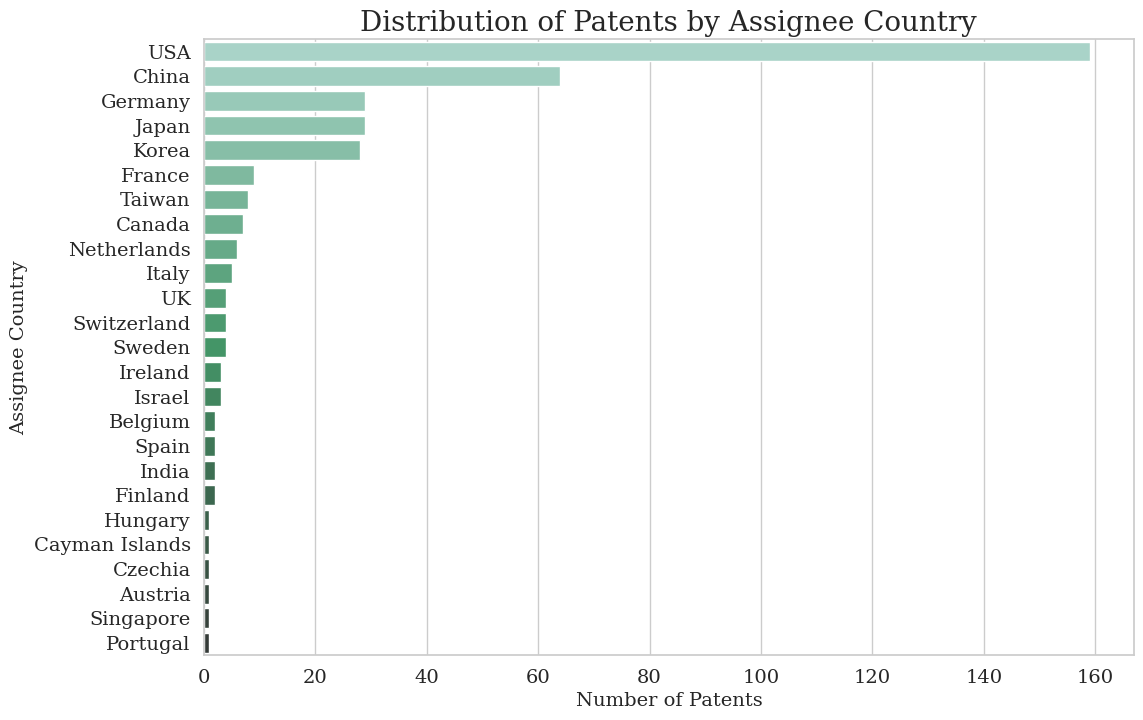

In [136]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from iso3166 import countries

# Assuming 'sofai' is your filtered dataframe

# Create a dictionary to map two-letter country codes to full names
country_dict = {country.alpha2: country.name for country in countries}

# Map the country codes to full names
sofai['assignee_country_full'] = sofai['assignee_country'].map(country_dict)

custom_labels = {
    'United States of America': 'USA',
    'United Kingdom of Great Britain and Northern Ireland': 'UK',
    'Korea, Republic of': 'Korea',
    'Taiwan, Province of China': 'Taiwan'
}
# Apply the custom labels
sofai['assignee_country_full'] = sofai['assignee_country_full'].replace(custom_labels)


# Count the number of patents by full country name
country_counts = sofai['assignee_country_full'].value_counts().sort_values(ascending=False)
# Create a color palette and reverse the order
palette = sns.color_palette('BuGn_d', len(country_counts))

# Create the plot
plt.figure(figsize=(12, 8))
sns.barplot(y=country_counts.index, x=country_counts.values, palette=palette)

# Set titles and labels
plt.title('Distribution of Patents by Assignee Country')
plt.xlabel('Number of Patents')
plt.ylabel('Assignee Country')

# Show the plot
plt.show()


In [45]:
len(abstracts)

548

In [6]:
# Load embeddings
# pre-calculated to improve efficiency
embeddings_specter = np.load('embeddings_specter_sofai.npy')

In [7]:
# prevent stochastic behaviour
umap_model = UMAP(n_neighbors=10, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

# control number of topics
hdbscan_model = HDBSCAN(min_cluster_size=10, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# improve representation by preprocessing topic representations after documents are assigned
vectorizer_model = CountVectorizer(stop_words="english", min_df=2, ngram_range=(1, 2))
vectorizer_model2 = CountVectorizer(stop_words=text.ENGLISH_STOP_WORDS.union(np.array(["method", "device", "apparatus", "system", "invention"])), min_df=2, ngram_range=(1, 2))
# use additional representations
# KeyBERT
keybert_model = KeyBERTInspired()

# MMR
mmr_model = MaximalMarginalRelevance(diversity=0.3)

# All representation models
representation_model = {
    "KeyBERT": keybert_model,
    "MMR": mmr_model
}

# embedding model
embedding_model_specter = SentenceTransformer("sentence-transformers/allenai-specter", revision=None)


## Zero shot modelling

In [8]:
stopwords_list = [
    "a", "needn", "a", "not", "able", "never",
    "about", "needn't", "accordance", "now", "above-", "often",
    "above", "no", "according", "of", "mentioned", "others",
    "after", "nor", "all", "on", "accordingly", "otherwise",
    "again", "not", "an", "or", "along", "rather",
    "ain", "o", "and", "other", "already", "remarkably",
    "all", "of", "another", "particularly", "alternatively", "significantly",
    "am", "off", "are", "preferably", "always", "simply",
    "an", "on", "as", "preferred", "among", "sometimes",
    "and", "once", "at", "present", "and/or", "specifically",
    "any", "only", "be", "provide", "anything", "straight",
    "are", "or", "because", "provided", "anywhere", "forward",
    "aren", "other", "been", "provides", "better", "substantially",
    "aren't", "our", "being", "relatively", "disclosure", "thereafter",
    "as", "ours", "by", "respectively", "due", "therebetween",
    "at", "ourselves", "claim", "said", "easily", "therefor",
    "be", "out", "comprises", "should", "easy", "therefrom",
    "because", "over", "corresponding", "since", "e.g", "therein",
    "been", "own", "could", "some", "either", "thereinto",
    "before", "re", "described", "such", "elsewhere", "thereon",
    "being", "s", "desired", "suitable", "enough", "therethrough",
    "below", "same", "do", "than", "especially", "therewith",
    "between", "shan", "does", "that", "essentially", "together",
    "both", "shan't", "each", "the", "et al", "toward",
    "but", "she", "embodiment", "their", "etc", "towards",
    "by", "she's", "fig", "then", "eventually", "typical",
    "can", "should", "figs", "there", "excellent", "upon",
    "couldn", "should've", "for", "thereby", "finally", "via",
    "couldn't", "shouldn", "from", "therefore", "furthermore", "vice versa",
    "d", "shouldn't", "further", "thereof", "good", "whatever",
    "did", "so", "generally", "thereto", "hence", "whereas",
    "didn", "some", "had", "these", "he/she", "whereat",
    "didn't", "such", "has", "they", "him/her", "wherever",
    "do", "t", "have", "this", "his/her", "whether",
    "does", "than", "having", "those", "ie", "whose",
    "doesn", "that", "herein", "thus", "ii", "within",
    "doesn't", "that'll", "however", "to", "iii", "without",
    "doing", "the", "if", "use", "instead", "yet",
    "don", "their", "in", "various", "later",
    "don't", "theirs", "into", "was", "like",
    "down", "them", "invention", "were", "little",
    "during", "themselves", "is", "what", "many",
    "each", "there", "it", "when", "may",
    "few", "these", "its", "where", "meanwhile",
    "for", "they", "means", "whereby", "might",
    "from", "this", "wherein", "moreover",
    "further", "those", "which", "much",
    "had", "through", "while", "must",
    "hadn", "to", "who",
    "hadn't", "too", "will",
    "has", "under", "with",
    "hasn", "until", "would",
    "hasn't", "up",
    "have", "ve",
    "haven", "very",
    "haven't", "was",
    "having", "wasn",
    "he", "wasn't",
    "her", "we",
    "here", "were",
    "hers", "weren",
    "herself", "weren't",
    "him", "what",
    "himself", "when",
    "his", "where",
    "how", "which",
    "i", "while",
    "if", "who",
    "in", "whom",
    "into", "why",
    "is", "will",
    "isn", "with",
    "isn't", "won",
    "it", "won't",
    "it's", "wouldn",
    "its", "wouldn't",
    "itself", "y",
    "just", "you",
    "ll", "you'd",
    "m", "you'll",
    "ma", "you're",
    "me", "you've",
    "mightn", "your",
    "mightn't", "yours",
    "more", "yourself",
    "most", "yourselves",
    "mustn",
    "mustn't",
    "my",
    "myself", "method", "system", "apparatus"
]


## 1 Operational view: 

Data:
- Data collection

AI operations:
- Model
- Infrastructure
    - Storage
    - Network
    - General hardware (e.g., Data center)
- Platform
- Specialised Hardware

In [9]:
vectorizer_model2 = CountVectorizer(stop_words=stopwords_list, ngram_range=(1, 2))

#zeroshot_topic_list = ["data acquisition and sensor technology", "data storage", "algorithmic design, layers, model", "computing hardware", "deployment, edge and cloud"]
#zeroshot_topic_list = ["sensor data collection, environmental monitoring, IoT sensors", "data storage, data warehouses, data management, data center, uninterruptible power supply, power factor correction, power transfer", "algorithmic design, model architecture, layer, deep learning, weights", "computing hardware, processors, GPU, cooling, memory", "power management, battery", "network infrastructure, bandwidth, data transmission", "deployment, edge and cloud"]
zeroshot_topic_list = [
    "sensor, data collection, environmental monitoring, IoT sensors", # data collection
    "storage, storage area network, network-attached storage, distributed file system" , # data storage
    "data center, uninterruptible power supply, power distribution unit, generator, cooling, ventilation, pump, chiller, low-precision hardware", # general data center infrastructure
    "algorithmic design, weights, pruned, parallelism, model compression", # model development
    "computation, specialized acceleration, application-specific integrated circuits, field-programmable gate array", # compute
    "network infrastructure, bandwidth, data transmission, routers, cable, switch, firewall, connectivity", # network
    "platform for optimization techniques, framework, library"
    #"deployment, edge and cloud, inference, inference prediction, production use case" # deployment
    ]

           
topic_model = BERTopic(embedding_model=embedding_model_specter, 
    min_topic_size=10,
    zeroshot_topic_list=zeroshot_topic_list,
    zeroshot_min_similarity=.57,
    vectorizer_model = vectorizer_model2,
    representation_model= representation_model
    #ctfidf_model=ctfidf_model
    )

# Train model
topics, probs = topic_model.fit_transform(abstracts, embeddings_specter)

# Show topics
topic_model.get_topic_info()

,Topic,Count,Name,Representation,KeyBERT,MMR,Representative_Docs
0,0,167,"computation, specialized acceleration, applica...","[processing, neural, network, data, neural net...","[chip, integrated circuit, processing device, ...","[processing, neural, network, data, neural net...",[integrated circuit chip deviceprovided are an...
1,1,121,"data center, uninterruptible power supply, pow...","[power, device, supply, input, power supply, v...","[power supplies, power supply, ac power, dc po...","[power, device, supply, input, power supply, v...",[method and apparatus for converting a dc volt...
2,2,75,"sensor, data collection, environmental monitor...","[model, image, learning, data, first, one, bas...","[technology, devices, device, application, com...","[model, image, learning, data, first, one, bas...","[federated learning method and apparatus, devi..."
3,3,67,"storage, storage area network, network-attache...","[data, memory, storage, processing, device, im...","[data storage, data stored, disk array, storag...","[data, memory, storage, processing, device, im...","[method and apparatus for balancing loads, and..."
4,4,64,"algorithmic design, weights, pruned, paralleli...","[graphics, data, processing, machine, learning...","[parallel graphics, graphics processors, graph...","[graphics, data, processing, machine, learning...",[compute optimizations for low precision machi...
5,5,29,"platform for optimization techniques, framewor...","[set, hotspot, data, set applications, workloa...","[application data, resource scheduling, worklo...","[set, hotspot, data, set applications, workloa...","[resource scheduling method and apparatus, dev..."
6,6,25,"network infrastructure, bandwidth, data transm...","[data, network, least, first, one, least one, ...","[data network, two networks, network, networks...","[data, network, least, first, one, least one, ...",[method for the digital evaluation of a data t...


In [25]:
timestamps = pd.to_datetime(sofai['publication_date_EPO'], format='%Y%m%d').to_list()
topics_over_time = topic_model.topics_over_time(abstracts, timestamps, nr_bins=20)
# or use one of the other topic representations, like KeyBERTInspired
topic_model.set_topic_labels({0: "Specialised hardware", 1: "General hardware", 2: "Data collection", 3: "Storage", 4: "Model", 5: "Platform", 6: "Network"})

topic_model.visualize_topics_over_time(topics_over_time, custom_labels=True)

In [229]:
topics_over_time

,Topic,Words,Frequency,Timestamp,Name
0,1,"power, lead, packing, input, output",4,2000-09-25 16:04:48,General hardware
1,2,"noise, sound, source, amplitude, certain",1,2000-09-25 16:04:48,Data collection
2,3,"cells, neural cells, methods storing, methods,...",1,2000-09-25 16:04:48,Storage
3,0,"clock, shared, shared component, component, pr...",1,2001-11-24 12:00:00,Specialised hardware
4,1,"power, microprocessor, supply, power supply, one",4,2001-11-24 12:00:00,General hardware
...,...,...,...,...,...
89,2,"model, learning, image, data, processing",17,2022-06-04 12:00:00,Data collection
90,3,"data, memory, storage, hierarchical, persistent",13,2022-06-04 12:00:00,Storage
91,4,"learning, machine, machine learning, graphics,...",12,2022-06-04 12:00:00,Model
92,5,"hotspot, data value, value, gpu, data",6,2022-06-04 12:00:00,Platform


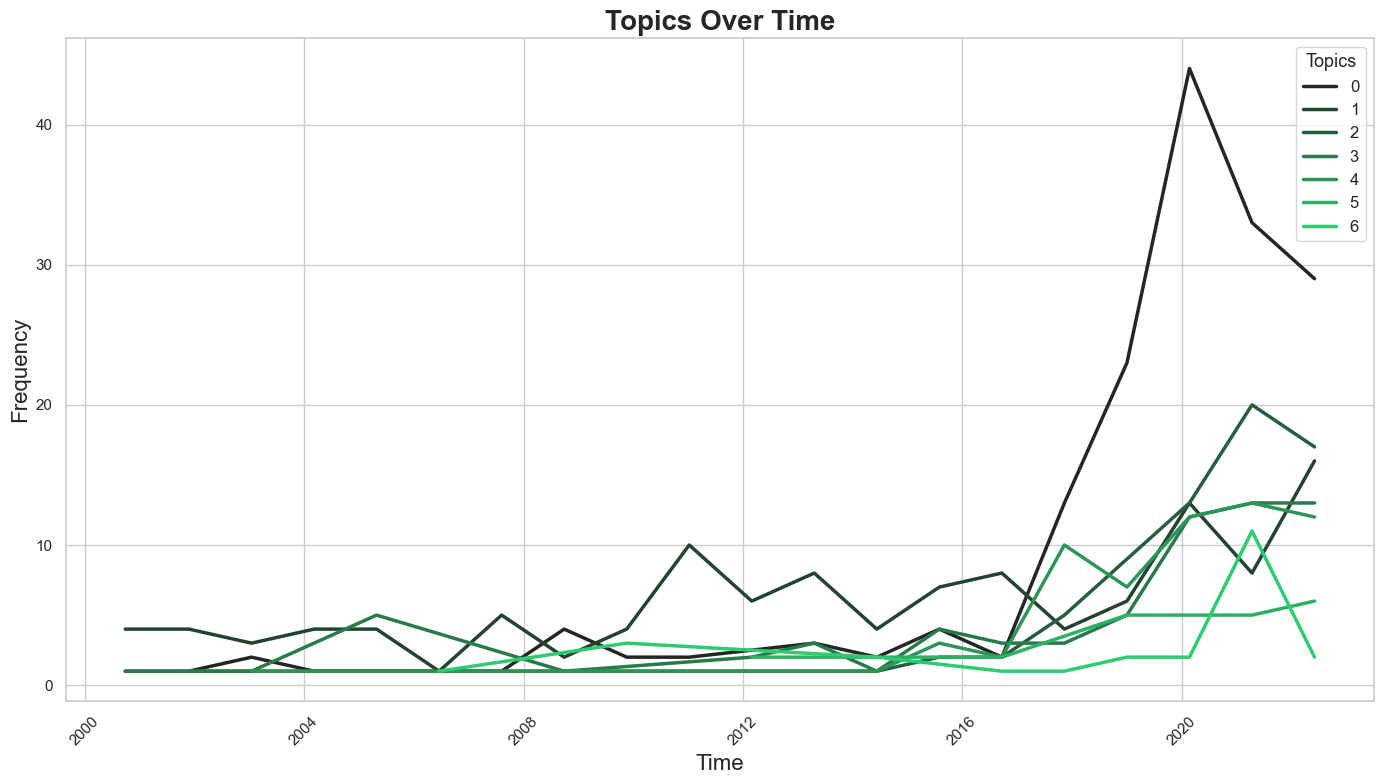

In [232]:
# Setting the topic labels
topic_labels = {0: "Specialised hardware", 1: "General hardware", 2: "Data collection", 3: "Storage", 4: "Model", 5: "Platform", 6: "Network"}

## Pivot the DataFrame to get the topics as columns
topics_pivot = topics_over_time.pivot(index='Timestamp', columns='Topic', values='Frequency')

# Set the style for the plot
sns.set(style="whitegrid")

# Create a color palette with shades of Seagreen
seagreen_palette = sns.color_palette("dark:#2ecc71", 7)  # 7 colors for the 7 topics

# Plotting with Seaborn
plt.figure(figsize=(14, 8))

# Loop through each topic and plot it
for idx, topic in enumerate(topics_pivot.columns):
    sns.lineplot(data=topics_pivot, x=topics_pivot.index, y=topic, label=topic, color=seagreen_palette[idx], linewidth=2.5)

# Customize the plot for a scientific paper look
plt.title('Topics Over Time', fontsize=20, fontweight='bold')
plt.xlabel('Time', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.xticks(rotation=45)
plt.legend(title='Topics', title_fontsize='13', fontsize='12')
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()

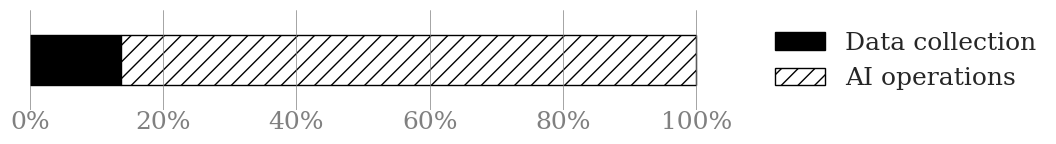

In [197]:
import pandas as pd
import matplotlib.pyplot as plt

# Data
topics = [
    "Data collection",
    "AI operations"
]


counts = [75, 548-75]

# Create a DataFrame
df = pd.DataFrame({
    'Topic': topics,
    'Count': counts
})

# Normalize the counts to percentages
total = sum(df['Count'])
df['Percentage'] = (df['Count'] / total) * 100

# Initialize the plot
fig, ax = plt.subplots(figsize=(10, 2))

# Add a light grey grid in the background
ax.set_facecolor('lightgrey')
ax.grid(which='major', axis='x', linestyle='--', color='white')

# Define colors and hatches
colors = ['#000000', 'white']
hatches = [None, '//']

# Plotting the single bar with segments
left = 0
for i, (percentage, color, hatch) in enumerate(zip(df['Percentage'], colors, hatches)):
    ax.barh(['AI pipeline'], percentage, left=left, color=color, edgecolor='black', hatch=hatch)
    left += percentage

# Adding vertical lines at every 20%
for i in range(0, 101, 20):
    ax.axvline(x=i, color='grey', linestyle='-', linewidth=0.5)
    ax.text(i, -1, f'{i}%', ha='center', va='center', color='grey', fontsize=18)  # Adding the percentage labels

ax.set_ylim(-0.8, 0.8)
legend_labels = df['Topic']
legend_colors = ['#000000', 'white']
legend_hatches = [None, '//']

# Create custom legend handles
handles = []
for color, hatch, label in zip(legend_colors, legend_hatches, legend_labels):
    patch = plt.Rectangle((0, 0), 1, 1, facecolor=color, edgecolor='black', hatch=hatch, label=label)
    handles.append(patch)
ax.legend(handles=handles, loc='lower left', bbox_to_anchor=(1.05, 0.1), borderaxespad=0, frameon=False, fontsize=18)


# Adding grid and labels
ax.set_xticks(range(0, 101, 20))
ax.set_xticklabels([f'{i}%' for i in range(0, 101, 20)])
ax.xaxis.tick_top()

# Removing axes for cleaner look
ax.axis('off')

# Adjusting the plot layout to avoid overlap
plt.subplots_adjust(left=0.05, right=0.75, top=0.85, bottom=0.35)

# Display the plot
plt.show()


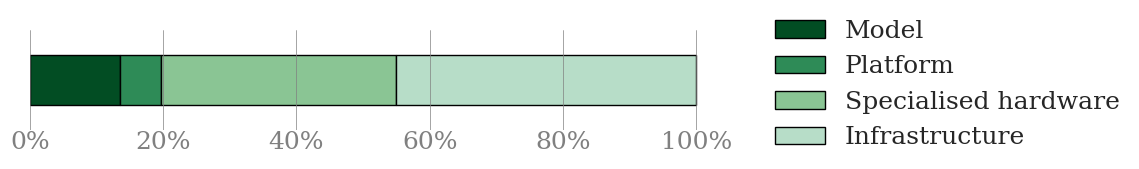

In [192]:
# Data
topics = [
    "Model",
    "Platform",
    "Specialised hardware",
    "Infrastructure"
]


counts = [64, 29, 167, 121+67+25]

# Create a DataFrame
df = pd.DataFrame({
    'Topic': topics,
    'Count': counts
})

# Normalize the counts to percentages
total = sum(df['Count'])
df['Percentage'] = (df['Count'] / total) * 100

# Initialize the plot
fig, ax = plt.subplots(figsize=(10, 2))

# Add a light grey grid in the background
ax.set_facecolor('lightgrey')
ax.grid(which='major', axis='x', linestyle='--', color='white')

# Define colors and hatches
colors = ['#024d23', '#2e8b57','#8ac594', '#b7ddc8']
hatches = [None, None, None, None]

# Plotting the single bar with segments
left = 0
for i, (percentage, color, hatch) in enumerate(zip(df['Percentage'], colors, hatches)):
    ax.barh(['AI pipeline'], percentage, left=left, color=color, edgecolor='black', hatch=hatch)
    left += percentage

# Adding vertical lines at every 20%
for i in range(0, 101, 20):
    ax.axvline(x=i, color='grey', linestyle='-', linewidth=0.5)
    ax.text(i, -1, f'{i}%', ha='center', va='center', color='grey', fontsize=18)  # Adding the percentage labels

ax.set_ylim(-0.8, 0.8)
legend_labels = df['Topic']
legend_colors = ['#024d23', '#2e8b57','#8ac594', '#b7ddc8']
legend_hatches = [None, None, None, None]

# Create custom legend handles
handles = []
for color, hatch, label in zip(legend_colors, legend_hatches, legend_labels):
    patch = plt.Rectangle((0, 0), 1, 1, facecolor=color, edgecolor='black', hatch=hatch, label=label)
    handles.append(patch)
ax.legend(handles=handles, loc='upper left', bbox_to_anchor=(1.05, 1.2), borderaxespad=0, frameon=False, fontsize=18)


# Adding grid and labels
ax.set_xticks(range(0, 101, 20))
ax.set_xticklabels([f'{i}%' for i in range(0, 101, 20)])
ax.xaxis.tick_top()

# Removing axes for cleaner look
ax.axis('off')

# Adjusting the plot layout to avoid overlap
plt.subplots_adjust(left=0.05, right=0.75, top=0.85, bottom=0.35)

# Display the plot
plt.show()



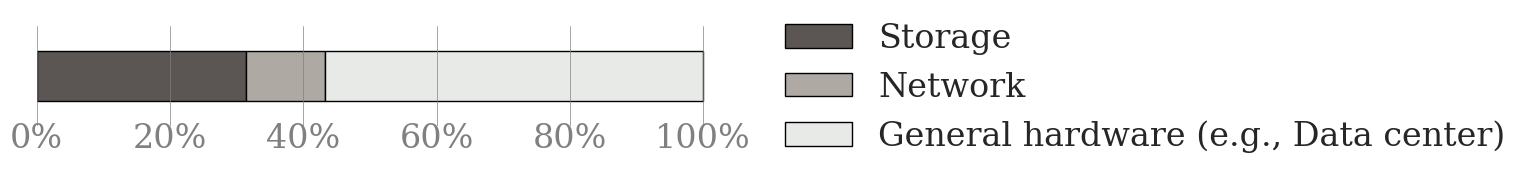

In [199]:
# Data
topics = [
    "Storage",
    "Network",
    "General hardware (e.g., Data center)"
]


counts = [67, 25, 121]

# Create a DataFrame
df = pd.DataFrame({
    'Topic': topics,
    'Count': counts
})

# Normalize the counts to percentages
total = sum(df['Count'])
df['Percentage'] = (df['Count'] / total) * 100

# Initialize the plot
fig, ax = plt.subplots(figsize=(10, 2))

# Add a light grey grid in the background
ax.set_facecolor('lightgrey')
ax.grid(which='major', axis='x', linestyle='--', color='white')

# Define colors and hatches
colors = ['#5b5653', '#aea9a2', '#e7eae7']
hatches = [None, None, None]

# Plotting the single bar with segments
left = 0
for i, (percentage, color, hatch) in enumerate(zip(df['Percentage'], colors, hatches)):
    ax.barh(['AI pipeline'], percentage, left=left, color=color, edgecolor='black', hatch=hatch)
    left += percentage

# Adding vertical lines at every 20%
for i in range(0, 101, 20):
    ax.axvline(x=i, color='grey', linestyle='-', linewidth=0.5)
    ax.text(i, -1, f'{i}%', ha='center', va='center', color='grey', fontsize=24)  # Adding the percentage labels

ax.set_ylim(-0.8, 0.8)
legend_labels = df['Topic']
legend_colors = ['#5b5653', '#aea9a2', '#e7eae7']
legend_hatches = [None, None, None]

# Create custom legend handles
handles = []
for color, hatch, label in zip(legend_colors, legend_hatches, legend_labels):
    patch = plt.Rectangle((0, 0), 1, 1, facecolor=color, edgecolor='black', hatch=hatch, label=label)
    handles.append(patch)
ax.legend(handles=handles, loc='lower left', bbox_to_anchor=(1.05, -0.4), borderaxespad=0, frameon=False, fontsize=24)


# Adding grid and labels
ax.set_xticks(range(0, 101, 20))
ax.set_xticklabels([f'{i}%' for i in range(0, 101, 20)])
ax.xaxis.tick_top()

# Removing axes for cleaner look
ax.axis('off')

# Adjusting the plot layout to avoid overlap
plt.subplots_adjust(left=0.05, right=0.75, top=0.85, bottom=0.35)

# Display the plot
plt.show()


# 

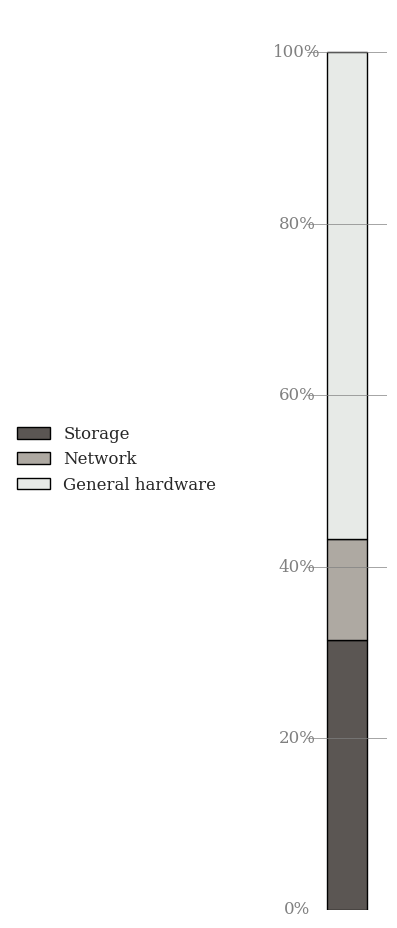

In [206]:
import matplotlib.pyplot as plt
import pandas as pd

# Data
topics = [
    "Storage",
    "Network",
    "General hardware"
]

counts = [67, 25, 121]

# Create a DataFrame
df = pd.DataFrame({
    'Topic': topics,
    'Count': counts
})

# Normalize the counts to percentages
total = sum(df['Count'])
df['Percentage'] = (df['Count'] / total) * 100

# Initialize the plot
fig, ax = plt.subplots(figsize=(2, 10))

# Add a light grey grid in the background
ax.set_facecolor('lightgrey')
ax.grid(which='major', axis='y', linestyle='--', color='white')

# Define colors and hatches
colors = ['#5b5653', '#aea9a2', '#e7eae7']
hatches = [None, None, None]

# Plotting the single bar with segments
bottom = 0
for i, (percentage, color, hatch) in enumerate(zip(df['Percentage'], colors, hatches)):
    ax.bar(['AI pipeline'], percentage, bottom=bottom, color=color, edgecolor='black', hatch=hatch)
    bottom += percentage

# Adding horizontal lines at every 20%
for i in range(0, 101, 20):
    ax.axhline(y=i, color='grey', linestyle='-', linewidth=0.5)
    ax.text(-1, i, f'{i}%', ha='center', va='center', color='grey', fontsize=12)  # Adding the percentage labels

ax.set_xlim(-0.8, 0.8)
legend_labels = df['Topic']
legend_colors = ['#5b5653', '#aea9a2', '#e7eae7']
legend_hatches = [None, None, None]

# Create custom legend handles
handles = []
for color, hatch, label in zip(legend_colors, legend_hatches, legend_labels):
    patch = plt.Rectangle((0, 0), 1, 1, facecolor=color, edgecolor='black', hatch=hatch, label=label)
    handles.append(patch)
ax.legend(handles=handles, loc='right', bbox_to_anchor=(-1.05, 0.5), borderaxespad=0, frameon=False, fontsize=12)

# Adding grid and labels
ax.set_yticks(range(0, 101, 20))
ax.set_yticklabels([f'{i}%' for i in range(0, 101, 20)])

# Removing axes for cleaner look
ax.axis('off')

# Adjusting the plot layout to avoid overlap
plt.subplots_adjust(left=0.35, right=0.75, top=0.95, bottom=0.05)

# Display the plot
plt.show()


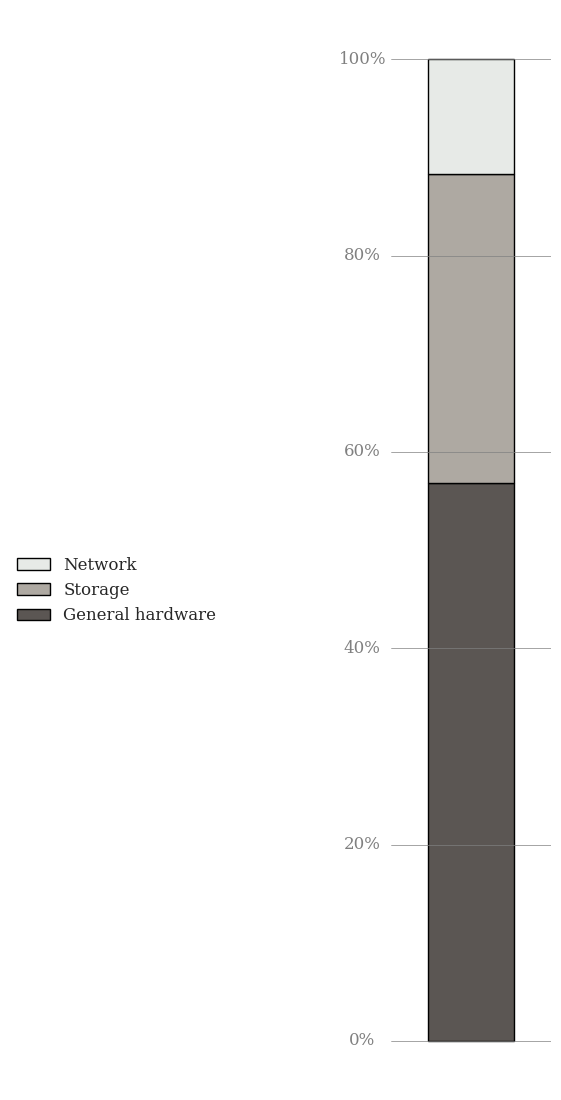

In [220]:
import matplotlib.pyplot as plt
import pandas as pd

# Data
topics = [
    "Storage",
    "Network",
    "General hardware"
]

counts = [67, 25, 121]

# Create a DataFrame
df = pd.DataFrame({
    'Topic': topics,
    'Count': counts
})

# Normalize the counts to percentages
total = sum(df['Count'])
df['Percentage'] = (df['Count'] / total) * 100

# Sort the DataFrame by 'Count' in descending order
df = df.sort_values(by='Count', ascending=False).reset_index(drop=True)

# Initialize the plot
fig, ax = plt.subplots(figsize=(4, 12))

# Add a light grey grid in the background
ax.set_facecolor('lightgrey')
ax.grid(which='major', axis='y', linestyle='--', color='white')

# Define colors and hatches
colors = ['#5b5653', '#aea9a2', '#e7eae7']
hatches = [None, None, None]

# Plotting the single bar with segments
bottom = 0.01
for i, (percentage, color, hatch) in enumerate(zip(df['Percentage'], colors, hatches)):
    ax.bar(['AI pipeline'], percentage, bottom=bottom, color=color, edgecolor='black', hatch=hatch)
    bottom += percentage

# Adding horizontal lines at every 20%
for i in range(0, 101, 20):
    ax.axhline(y=i, color='grey', linestyle='-', linewidth=0.5)
    ax.text(-1.02, i, f'{i}%', ha='center', va='center', color='grey', fontsize=12)  # Adding the percentage labels

ax.set_xlim(-0.75, 0.75)
legend_labels = df['Topic'][::-1]  # Reverse the order of labels
legend_colors = colors[:len(df)][::-1]  # Reverse the order of colors
legend_hatches = hatches[:len(df)][::-1] 

# Create custom legend handles
handles = []
for color, hatch, label in zip(legend_colors, legend_hatches, legend_labels):
    patch = plt.Rectangle((0, 0), 1, 1, facecolor=color, edgecolor='black', hatch=hatch, label=label)
    handles.append(patch)
ax.legend(handles=handles, loc='upper right', bbox_to_anchor=(-1.05, 0.5), borderaxespad=0, frameon=False, fontsize=12)

# Adding grid and labels
ax.set_yticks(range(0, 101, 20))
ax.set_yticklabels([f'{i}%' for i in range(0, 101, 20)])

# Removing axes for cleaner look
ax.axis('off')

# Adjusting the plot layout to avoid overlap
plt.subplots_adjust(left=0.35, right=0.75, top=0.95, bottom=0.05)

# Display the plot
plt.show()


In [ ]:
desired_topic = 0  # replace with your desired topic number
import textwrap
# Extract documents for the desired topic
documents_for_desired_topic = [doc for doc, topic in zip(abstracts, topics) if topic == desired_topic]

print(len(documents_for_desired_topic))

print(f"Documents for topic {desired_topic}:")
for doc in documents_for_desired_topic:
    wrapped_doc = textwrap.fill(doc, width=80)
    print(wrapped_doc)
    print("\n" + "="*80 + "\n") 

In [127]:
pd.set_option('display.max_columns', None)
pd.reset_option('display.max_colwidth', None)
patents_text[patents_text.title == "method and apparatus for using entropy in ant colony optimization circuit design from high level systhesis"]

,country,number,kind,publication_date_EPO,title_de_EPO,title_en_EPO,title_fr_EPO,abstract_de_EPO,abstract_en_EPO,abstract_fr_EPO,applicant_names,applicant_countries,inventor_EPO,inventor_countries,ipc_codes_EPO,cpc_codes_EPO,family_id,application_number,claims_de,claims_en,claims_fr,description_de,description_en,description_fr,publication_number_EPO,publication_date_google,filing_date,inventor_google,abstract_en_google,title_en_google,abstract_fr_google,title_fr_google,abstract_de_google,title_de_google,assignee_name,assignee_country,cpc_codes_google,ipc_codes_google,publication_number_GPO,title_GPO,assignee_name_GPO,inventor_name_GPO,priority_date_GPO,filing_date_GPO,publication_date_GPO,grant_date_GPO,lang_title_en_EPO,lang_title_en_google,translated_abstract,translated_descr,translated_claims,abstract,description,claims,title_en_EPO_lang,title_en_google_lang,title,SofAI,AIforS
8213,EP,2622549,A1,20130807,VERFAHREN UND VORRICHTUNG ZUR VERWENDUNG EINER...,method and apparatus for using entropy in ant ...,PROCÉDÉ ET APPAREIL PERMETTANT D'UTILISER L'EN...,NaN,NaN,NaN,"['SYNOPSYS, INC']",['US'],"['ISPIR, MUSTAFA, ', 'OKTEM, LEVENT']","['TR', 'TR']","['G06Q 10/ 00 A I', 'G06F 17/ ...","['G06F 30/34', 'G06Q 10/06', 'G06Q 50/04', 'G0...",45938606,11832913,NaN,NaN,NaN,NaN,NaN,NaN,EP-2622549-A1,20130807.0,20110831.0,"[ISPIR, MUSTAFA,OKTEM, LEVENT]",a method and apparatus for using entropy in an...,method and apparatus for using entropy in ant ...,L'invention concerne un procédé et un appareil...,Procédé et appareil permettant d'utiliser l'en...,NaN,Verfahren und vorrichtung zur verwendung einer...,SYNOPSYS INC,US,"['G06Q50/04', 'G06F2111/06', 'G06Q10/06', 'G06...","['G06F17/50', 'G06Q10/00']",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en,en,NaN,NaN,NaN,a method and apparatus for using entropy in an...,,,en,en,method and apparatus for using entropy in ant ...,1.0,0.0


# Pipeline view
lets not do that, not sure how I'd be able to distinguish

In [104]:
vectorizer_model2 = CountVectorizer(stop_words=stopwords_list, ngram_range=(1, 2))

#zeroshot_topic_list = ["data acquisition and sensor technology", "data storage", "algorithmic design, layers, model", "computing hardware", "deployment, edge and cloud"]
#zeroshot_topic_list = ["sensor data collection, environmental monitoring, IoT sensors", "data storage, data warehouses, data management, data center, uninterruptible power supply, power factor correction, power transfer", "algorithmic design, model architecture, layer, deep learning, weights", "computing hardware, processors, GPU, cooling, memory", "power management, battery", "network infrastructure, bandwidth, data transmission", "deployment, edge and cloud"]
zeroshot_topic_list = [
    "sensor data collection, environmental monitoring, IoT sensors", # data collection
    "model training",
    "inference and deployment"]

zeroshot_topic_list2 = [
    "data collection", 
    "data storage", 
    "data center infrastructure", 
    "algorithmic design (theoretical)", 
    "compute and processing", 
    "network", 
    "deployment"]
           
topic_model = BERTopic(embedding_model=embedding_model_specter, 
    min_topic_size=10,
    zeroshot_topic_list=zeroshot_topic_list,
    zeroshot_min_similarity=.75,
    vectorizer_model = vectorizer_model2,
    representation_model= representation_model
    #ctfidf_model=ctfidf_model
    )

# Train model
topics, probs = topic_model.fit_transform(abstracts, embeddings_specter)

# Show topics
topic_model.get_topic_info()

,Topic,Count,Name,Representation,KeyBERT,MMR,Representative_Docs
0,-1,224,0_neural_network_neural network_data,"[neural, network, neural network, data, model,...",NaN,NaN,NaN
1,0,58,"sensor data collection, environmental monitori...","[processing, data, first, model, signal, featu...","[data processing, processing unit, processing ...","[processing, data, first, model, signal, featu...","[image processing method, and task data proces..."
2,1,28,model training,"[learning, model, ml, federated, federated lea...","[machine learning, learning model, model train...","[learning, model, ml, federated, federated lea...",[data learning server and method for generatin...
3,2,11,inference and deployment,"[learning, machine, machine learning, deployme...","[deployment, existing, first deployment, first...","[learning, machine, machine learning, deployme...",[allocating cloud resources in accordance with...
4,3,48,1_graphics_processing_matrix_instruction,"[graphics, processing, matrix, instruction, op...","[deep neural, neural network, neural networks,...","[neural, network, neural network, data, model,...",[method for accelerating operations and accele...
5,4,46,2_power_processor_clock_core,"[power, processor, clock, core, processing, co...","[parallel graphics, graphics processors, multi...","[graphics, processing, matrix, instruction, op...",[processing method and accelerating devicethe ...
6,5,38,3_power_supply_power supply_dc,"[power, supply, power supply, dc, ac, ups, dev...","[microprocessor, power management, power suppl...","[power, processor, clock, core, processing, co...",[compute optimizations for low precision machi...
7,6,34,4_memory_bus_data_access,"[memory, bus, data, access, one, processing, p...","[dc power, power supplies, dc bus, dc voltage,...","[power, supply, power supply, dc, ac, ups, dev...",[methods and apparatus to estimate power perfo...
8,7,28,5_voice_recognition_voice recognition_device,"[voice, recognition, voice recognition, device...","[memory access, persistent memory, data stored...","[memory, bus, data, access, one, processing, p...",[decentralized module-based dc data centeracco...
9,8,17,6_data_one_network_virtual,"[data, one, network, virtual, sled, data netwo...","[using voice, voice operation, voice input, vo...","[voice, recognition, voice recognition, device...",[memory resource optimization method and appar...


In [105]:
desired_topic = 5  # replace with your desired topic number
import textwrap
# Extract documents for the desired topic
documents_for_desired_topic = [doc for doc, topic in zip(abstracts, topics) if topic == desired_topic]

print(len(documents_for_desired_topic))

print(f"Documents for topic {desired_topic}:")
for doc in documents_for_desired_topic:
    wrapped_doc = textwrap.fill(doc, width=80)
    print(wrapped_doc)
    print("\n" + "="*80 + "\n") 


38
Documents for topic 5:
lead alloy for making grids for batteriesa lead-tin-calcium casting alloy,
containing an age hardening accelerator, is new. a lead accumulator grid alloy
contains, in addition to lead, tin and calcium main components, an accelerator
which accelera age hardening during casting and which additionally increases the
final hardness of the alloy. independent claims are also included for the
following: (i) a lead accumulator grid produced from the above alloy by
continuous casting; and (ii) an accumulator with positive and negative
electrodes comprising grids as described above in the coated state. preferred
features: the accelerator is sr, li and/or mg.the present invention relates to a
lead alloy for the production of lead grids for accumulators it also relates to
a new type of lead grid and an accumulator constructed with this lead alloys for
the production of lead grids for accumulators are known in large numbers and in
various variations tried and tested alloys 

In [ ]:
topic_model.representative_docs_

In [38]:
# or use one of the other topic representations, like KeyBERTInspired
topic_model.set_topic_labels({0: "Compute/hardware", 1: "Data collection", 2: "Data storage", 3: "General compute infrastructure", 4: "Algorithmic design", 5: "Network infrastructure", 6: "Deployment"})


In [59]:
topic_model.visualize_heatmap(top_n_topics=7, custom_labels=True)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style and context for a scientific article
sns.set(style="whitegrid")
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

# Data
topics = [
    
    "Data collection",
    "Data storage",
    "General compute infrastructure",
    "Compute/hardware",
    "Network infrastructure",
    "Algorithmic design",
    "Deployment"
]

counts = [103, 90, 86, 132, 46, 68, 23]

# Create a seaborn barplot
fig, ax = plt.subplots(figsize=(12, 10))
sns.barplot(x=topics, y=counts, palette="BuGn_d", ax=ax)

# Adding text labels
for i, count in enumerate(counts):
    ax.text(i, count + 5, f'{count}', ha='center', va='bottom', fontsize=16, color='black')

# Title and labels
ax.set_title('AI Technology Patents by Pipeline Stage', fontsize=20)
ax.set_ylabel('Number of Patents', fontsize=18)
ax.set_xlabel('Pipeline Stage', fontsize=18)

# Rotate x labels
plt.xticks(rotation=45, ha='right')

# Styling
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Set the style and context for a scientific article
sns.set(style="whitegrid")
plt.rcParams['font.family'] = 'serif'
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

# Data
topics = [
    "Data collection",
    "General compute infrastructure",
    "Storage",
    "Compute/hardware",
    "Network infrastructure",
    "Algorithmic design",
    "Deployment"
]

counts = [83, 82, 91, 129, 44, 67, 52]

# Adjusted positions to create gaps
positions = [0, 2, 3, 4, 5, 6, 8]

# Create a seaborn barplot
fig, ax = plt.subplots(figsize=(12, 10))
bars = ax.bar(positions, counts, color=sns.color_palette("BuGn_d", 7))

# Adding text labels
for bar in bars:
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, f'{int(bar.get_height())}', 
            ha='center', va='bottom', fontsize=18, color='black')

# Title and labels
ax.set_title('AI Technology Patents by Pipeline Stage', fontsize=20, pad=40)
ax.set_ylabel('Number of Patents', fontsize=18)
ax.set_xlabel('Pipeline Stage', fontsize=18)

# Rotate x labels
plt.xticks(positions, [
    "Data collection",
    "General compute infrastructure",
    "Data storage",
    "Compute/hardware",
    "Network infrastructure",
    "Algorithmic design",
    "Deployment"
], rotation=45, ha='right')

# Styling
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(axis='y', linestyle='-', alpha=0.7)
ax.grid(False, axis='x')

plt.tight_layout()
plt.show()


In [ ]:
# Run the visualization with the original embeddings
topic_model.visualize_document_datamap(abstracts, embeddings=embeddings_specter, custom_labels=True)

# with the reduced embeddings
reduced_embeddings = UMAP(n_neighbors=15, n_components=2, min_dist=0.05, metric='cosine').fit_transform(embeddings_specter)
topic_model.visualize_document_datamap(abstracts, reduced_embeddings=reduced_embeddings, custom_labels=True)


In [ ]:
timestamps = pd.to_datetime(sofai['publication_date_EPO'], format='%Y%m%d').to_list()
topics_over_time = topic_model.topics_over_time(abstracts, timestamps, nr_bins=18)

topic_model.visualize_topics_over_time(topics_over_time, custom_labels=True)

# Sustainability levers

In [26]:
sofai['text'] = sofai['title'] + " " + sofai['abstract'] + " " + sofai['description'].fillna('')

In [29]:
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import textwrap

# Lists of keywords for each category
keywords_water = ["water-efficient", "water-saving", "reduced water use"]
keywords_energy = ["energy efficiency", "low power", "energy saving", "power reduction", "energy efficient", "energy-efficient", "power efficiency"]
keywords_waste = ["recyclable", "waste reduction", "biodegradable", "recycled materials"]
keywords_carbon = ['low emission', 'reduced carbon footprint', 'carbon reduction']
keywords_metals = ["rare-earth-free", "alternative materials", "reduced metal usage"]
keywords_lifetime = ["durability", "longevity", "extended life", "increase lifetime"]

keywords_water2 = ['water consumption', 'water usage', "water"]
keywords_energy2 = ['energy consumption', 'energy usage', "electricity consumption", "electricity usage", "energy", "electricity", "power consumption", "runtime", "run time"]
keywords_waste2 = ['waste', 'recycling']
keywords_carbon2 = ['emissions', 'carbon footprint', 'carbon reduction']
keywords_metals2 = ['rare metal', "niobium", "aluminium", "europium", "gold", "silver",
                   "platinum", "palladium", " tin ", "tantalum", 
                   "tungsten", "bismuth", "cadmium", "cobalt",
                    "gallium", "germanium", "indium", "lithium",
                     "molybdenum", "selenium", "tellurium", "vanadium",
                     "zirconium"]

def search_abstracts_for_keywords_with_context(abstracts, primary_keywords, secondary_keywords=None, context_words=['less', 'reduce', "reduction", "lower", "optimize", "optimization"], context_range=3):
    keyword_presence = []
    matching_indices = []
    for index, abstract in enumerate(abstracts):
        found_keyword = False
        words = re.findall(r'\w+', abstract.lower())  # Tokenize the abstract into words
        for i, word in enumerate(words):
            # Check primary keywords
            for keyword in primary_keywords:
                if keyword.lower() in word:  # Check if the word is a primary keyword
                    found_keyword = True
                    matching_indices.append(index)
                    break
            # Check secondary keywords with context words
            if secondary_keywords and not found_keyword:
                for keyword in secondary_keywords:
                    if keyword.lower() in word:  # Check if the word is a secondary keyword
                        start = max(0, i - context_range)
                        end = min(len(words), i + context_range + 1)
                        context = words[start:i] + words[i+1:end]
                        if any(context_word in context for context_word in context_words):
                            found_keyword = True
                            matching_indices.append(index)
                            break
            if found_keyword:
                break
        keyword_presence.append(found_keyword)
    return keyword_presence, matching_indices

def count_patents_by_keywords(abstracts, keyword_lists, secondary_keyword_lists=None, context_words=['less', 'reduce', "reduction", "lower", "optimize", "optimization"], context_range=5):
    keyword_counts = {}
    example_abstracts = {}
    for category, keywords in keyword_lists.items():
        secondary_keywords = secondary_keyword_lists.get(category, None) if secondary_keyword_lists else None
        presence, indices = search_abstracts_for_keywords_with_context(abstracts, keywords, secondary_keywords, context_words, context_range)
        keyword_counts[category] = sum(presence)
        example_abstracts[category] = [abstracts[i] for i in indices[:5] if i < len(abstracts)]  # Get up to 5 example abstracts within valid range
    return keyword_counts, example_abstracts

def wrap_text(text, width=70):
    return textwrap.fill(text, width)

# Define the categories and their keywords
keyword_lists = {
    'Water': keywords_water,
    'Energy': keywords_energy,
    'Waste': keywords_waste,
    'Carbon': keywords_carbon,
    'Metals': keywords_metals,
    'Lifetime': keywords_lifetime
}

secondary_keyword_lists = {
    'Water': keywords_water2,
    'Energy': keywords_energy2,
    'Waste': keywords_waste2,
    'Carbon': keywords_carbon2,
    'Metals': keywords_metals2
}

# Assuming 'sofai' DataFrame and 'text' column exist
abstracts = sofai['text'].dropna().tolist()  # Drop any NaN values and convert to list
print(f"Number of abstracts: {len(abstracts)}")

# Count patents mentioning keywords in each category and get example abstracts
patent_counts, example_abstracts = count_patents_by_keywords(abstracts, keyword_lists, secondary_keyword_lists)

# Plot the results using Seaborn
categories = list(patent_counts.keys())
counts = list(patent_counts.values())

plt.figure(figsize=(10, 6))
sns.barplot(x=categories, y=counts, palette='BuGn_d')
plt.xlabel('Keyword Categories')
plt.ylabel('Number of Patents')
plt.title('Number of Patents Mentioning Keywords by Category')
plt.xticks(rotation=45)
sns.despine()
plt.show()

# Display example abstracts for each category
for category, examples in example_abstracts.items():
    print(f"\nCategory: {category}")
    for i, example in enumerate(examples):
        wrapped_example = wrap_text(example, width=120)
        print(f"Example {i+1}: {wrapped_example}")


KeyError: 'text'

## larger SofAI

In [260]:
sofai_large = patents_text[patents_text['SofAI'] == 1]

def extract_first_300_words(text):
    words = re.findall(r'\b\w+\b', text)
    return ' '.join(words[:300])
abstracts_large = sofai_large['title'] + sofai_large['abstract'] + sofai_large["description"].fillna('').apply(extract_first_300_words)
abstracts_large = abstracts_large.apply(str).tolist()

Number of abstracts: 3048


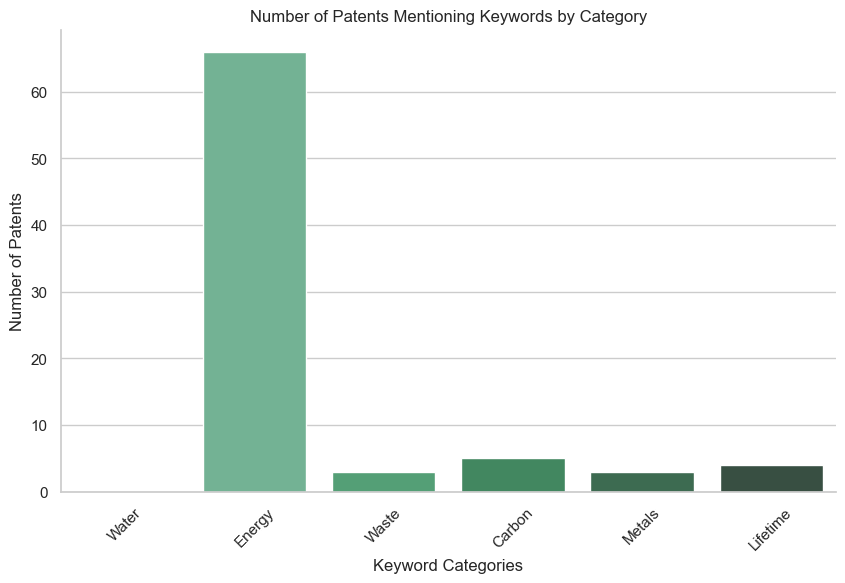


Category: Water

Category: Energy
Example 1: microprocessor controlled electronic ballastan electronic ballast includes an ac to dc converter  for power factor
correction, a bulk capacitor  for storing energy from the converter, and a microprocessor controlled, half-bridge
inverter  including a series resonant, direct coupled output . input ports of the microprocessor  are coupled to several
locations within the ballast to monitor the operation of the ballast or the operation of a gas discharge lamp coupled to
the ballast. an analog voltage limiter (q) overrides the microprocessor to limit output voltage under fault conditions.
a storage capacitor , connected in series with the bulk capacitor , stores energy at low voltage for powering the
microprocessor. the microprocessor is programmed to provide lamp protection features, lumen maintenance, and a warm-up
period for a lamp. the microprocessor is also programmed to meet the operating requirements of world markets and of
different lamp

In [263]:
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import textwrap

# Lists of keywords for each category
keywords_water = ["water-efficient", "water-saving", "reduced water use"]
keywords_energy = ["energy efficiency", "low power", "energy saving", "power reduction", "energy efficient", "energy-efficient", "power efficiency"]
keywords_waste = ["recyclable", "waste reduction", "biodegradable", "recycled materials"]
keywords_carbon = ['low emission', 'reduced carbon footprint', 'carbon reduction']
keywords_metals = ["rare-earth-free", "alternative materials", "reduced metal usage"]
keywords_lifetime = ["durability", "longevity", "extended life", "increase lifetime"]

keywords_water2 = ['water consumption', 'water usage', "water"]
keywords_energy2 = ['energy consumption', 'energy usage', "electricity consumption", "electricity usage", "energy", "electricity", "power consumption", "runtime", "run time"]
keywords_waste2 = ['waste', 'recycling']
keywords_carbon2 = ['emissions', 'carbon footprint', 'carbon reduction']
keywords_metals2 = ['rare metal', "niobium", "aluminium", "europium", "gold", "silver",
                   "platinum", "palladium", "tin", "tantalum", 
                   "tungsten", "bismuth", "cadmium", "cobalt",
                   "gallium", "germanium", "indium", "lithium",
                   "molybdenum", "selenium", "tellurium", "vanadium",
                   "zirconium"]

def search_abstracts_for_keywords_with_context(abstracts, primary_keywords, secondary_keywords=None, context_words=['less', 'reduce', "reduction", "lower", "optimize", "optimization", "low"], context_range=3):
    keyword_presence = []
    matching_indices = []
    for index, abstract in enumerate(abstracts):
        found_keyword = False
        words = re.findall(r'\w+', abstract.lower())  # Tokenize the abstract into words
        for i, word in enumerate(words):
            # Check primary keywords
            if any(re.search(r'\b{}\b'.format(re.escape(keyword.lower())), word) for keyword in primary_keywords):
                found_keyword = True
                matching_indices.append(index)
                break
            # Check secondary keywords with context words
            if secondary_keywords and not found_keyword:
                for keyword in secondary_keywords:
                    if re.search(r'\b{}\b'.format(re.escape(keyword.lower())), word):
                        start = max(0, i - context_range)
                        end = min(len(words), i + context_range + 1)
                        context = words[start:i] + words[i+1:end]
                        if any(context_word in context for context_word in context_words):
                            found_keyword = True
                            matching_indices.append(index)
                            break
            if found_keyword:
                break
        keyword_presence.append(found_keyword)
    return keyword_presence, matching_indices

def count_patents_by_keywords(abstracts, keyword_lists, secondary_keyword_lists=None, context_words=['less', 'reduce', "reduction", "lower", "optimize", "optimization", "low"], context_range=5):
    keyword_counts = {}
    example_abstracts = {}
    for category, keywords in keyword_lists.items():
        secondary_keywords = secondary_keyword_lists.get(category, None) if secondary_keyword_lists else None
        presence, indices = search_abstracts_for_keywords_with_context(abstracts, keywords, secondary_keywords, context_words, context_range)
        keyword_counts[category] = sum(presence)
        example_abstracts[category] = [abstracts[i] for i in indices[:5] if i < len(abstracts)]  # Get up to 5 example abstracts within valid range
    return keyword_counts, example_abstracts

def wrap_text(text, width=70):
    return textwrap.fill(text, width)

# Define the categories and their keywords
keyword_lists = {
    'Water': keywords_water,
    'Energy': keywords_energy,
    'Waste': keywords_waste,
    'Carbon': keywords_carbon,
    'Metals': keywords_metals,
    'Lifetime': keywords_lifetime
}

secondary_keyword_lists = {
    'Water': keywords_water2,
    'Energy': keywords_energy2,
    'Waste': keywords_waste2,
    'Carbon': keywords_carbon2,
    'Metals': keywords_metals2
}

# Assuming 'sofai_large' DataFrame and 'text' column exist
abstracts = sofai_large['text'].dropna().tolist()  # Drop any NaN values and convert to list
print(f"Number of abstracts: {len(abstracts)}")

# Count patents mentioning keywords in each category and get example abstracts
patent_counts, example_abstracts = count_patents_by_keywords(abstracts, keyword_lists, secondary_keyword_lists)

# Plot the results using Seaborn
categories = list(patent_counts.keys())
counts = list(patent_counts.values())

plt.figure(figsize=(10, 6))
sns.barplot(x=categories, y=counts, palette='BuGn_d')
plt.xlabel('Keyword Categories')
plt.ylabel('Number of Patents')
plt.title('Number of Patents Mentioning Keywords by Category')
plt.xticks(rotation=45)
sns.despine()
plt.show()

# Display example abstracts for each category
for category, examples in example_abstracts.items():
    print(f"\nCategory: {category}")
    for i, example in enumerate(examples):
        wrapped_example = wrap_text(example, width=120)
        print(f"Example {i+1}: {wrapped_example}")


In [142]:
embeddings_specter_sofai_large = np.load('embeddings_specter_sofai_large.npy')

In [158]:
vectorizer_model2 = CountVectorizer(stop_words=stopwords_list, ngram_range=(1, 2))

#zeroshot_topic_list = ["data acquisition and sensor technology", "data storage", "algorithmic design, layers, model", "computing hardware", "deployment, edge and cloud"]
#zeroshot_topic_list = ["sensor data collection, environmental monitoring, IoT sensors", "data storage, data warehouses, data management, data center, uninterruptible power supply, power factor correction, power transfer", "algorithmic design, model architecture, layer, deep learning, weights", "computing hardware, processors, GPU, cooling, memory", "power management, battery", "network infrastructure, bandwidth, data transmission", "deployment, edge and cloud"]
zeroshot_topic_list = [
    "sensor, data collection, environmental monitoring, IoT sensors", # data collection
    "storage, storage area network, network-attached storage, distributed file system" , # data storage
    "data center, uninterruptible power supply, power distribution unit, generator, cooling, ventilation, pump, chiller, low-precision hardware", # general data center infrastructure
    "algorithmic design, weights, pruned, parallelism, model compression", # model development
    "computation, specialized acceleration, application-specific integrated circuits, field-programmable gate array", # compute
    "network infrastructure, bandwidth, data transmission, routers, cable, switch, firewall, connectivity", # network
    "platform for optimization techniques, framework, library"
    #"deployment, edge and cloud, inference, inference prediction, production use case" # deployment
    ]

           
topic_model = BERTopic(embedding_model=embedding_model_specter, 
    min_topic_size=80,
    zeroshot_topic_list=zeroshot_topic_list,
    zeroshot_min_similarity=.56,
    vectorizer_model = vectorizer_model2,
    representation_model= representation_model
    #ctfidf_model=ctfidf_model
    )

# Train model
topics, probs = topic_model.fit_transform(abstracts_large, embeddings_specter_sofai_large)

# Show topics
topic_model.get_topic_info()

,Topic,Count,Name,Representation,KeyBERT,MMR,Representative_Docs
0,0,2110,"data center, uninterruptible power supply, pow...","[power, voltage, input, circuit, output, dc, c...","[power converter, power supply, ac power, dc p...","[power, voltage, input, circuit, output, dc, c...",[power supply apparatusan electronic apparatus...
1,1,239,"computation, specialized acceleration, applica...","[processing, data, neural, neural network, net...","[chip, integrated circuit, neural networks, ha...","[processing, data, neural, neural network, net...",[artificial intelligence processor and method ...
2,2,238,"network infrastructure, bandwidth, data transm...","[network, data, communication, device, transmi...","[ethernet, wireless, device, devices, configur...","[network, data, communication, device, transmi...","[signal encoding method and apparatus, united ..."
3,3,178,"sensor, data collection, environmental monitor...","[data, model, device, learning, processing, im...","[wireless, technology, power consumption, devi...","[data, model, device, learning, processing, im...",[systems and methods for preventing machine le...
4,4,151,"storage, storage area network, network-attache...","[memory, data, storage, device, information, p...","[memory device, memory devices, storage device...","[memory, data, storage, device, information, p...",[integrated circuit i/o using a high performan...
5,5,80,"algorithmic design, weights, pruned, paralleli...","[graphics, data, processing, learning, machine...","[parallel graphics, graphics processors, graph...","[graphics, data, processing, learning, machine...",[compute optimizations for low precision machi...
6,6,52,"platform for optimization techniques, framewor...","[data, set, powertrain, hotspot, set applicati...","[component placement, resource scheduling, spe...","[data, set, powertrain, hotspot, set applicati...",[powertrain controllerthe present invention re...


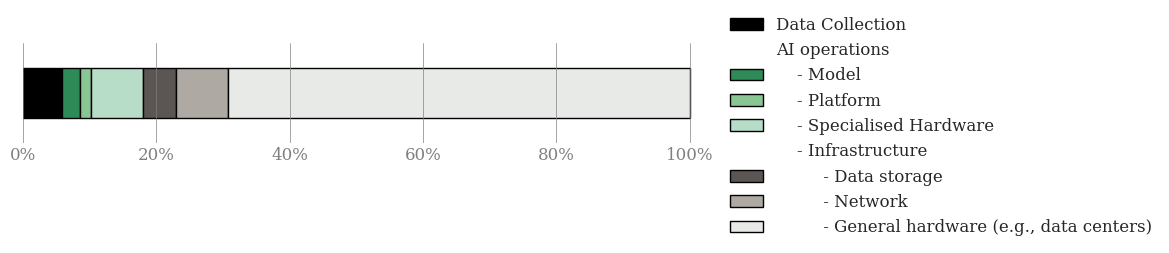

In [184]:

['#5b5653', '#aea9a2', '#e7eae7']

# Data
topics = [
    "Data collection",
    "Model",
    "Platform",
    "Specialised Hardware",
    "Data storage",
    "Network",
    "General hardware (e.g., data centers)"
]


counts = [178, 80, 52, 239, 151, 238, 2110]

# Create a DataFrame
df = pd.DataFrame({
    'Topic': topics,
    'Count': counts
})

# Normalize the counts to percentages
total = sum(df['Count'])
df['Percentage'] = (df['Count'] / total) * 100

# Initialize the plot
fig, ax = plt.subplots(figsize=(10, 2))

# Add a light grey grid in the background
ax.set_facecolor('lightgrey')
ax.grid(which='major', axis='x', linestyle='--', color='white')

# Define colors and hatches
colors = ["black", '#2e8b57','#8ac594','#b7ddc8', '#5b5653', '#aea9a2', '#e7eae7']
hatches = [None, None, None, None, None, None, None]

# Plotting the single bar with segments
left = 0
for i, (percentage, color, hatch) in enumerate(zip(df['Percentage'], colors, hatches)):
    ax.barh(['AI pipeline'], percentage, left=left, color=color, edgecolor='black', hatch=hatch)
    left += percentage

# Adding vertical lines at every 20%
for i in range(0, 101, 20):
    ax.axvline(x=i, color='grey', linestyle='-', linewidth=0.5)
    ax.text(i, -1, f'{i}%', ha='center', va='center', color='grey', fontsize=12)  # Adding the percentage labels

ax.set_ylim(-0.8, 0.8)
# Custom legend structure
legend_labels = [
    "Data Collection",
    "AI operations",
    "Model",
    "Platform",
    "Specialised Hardware",
    "Infrastructure",
    "Data storage",
    "Network",
    "General hardware (e.g., data centers)"
]

legend_colors = ['black', None, '#2e8b57', '#8ac594', '#b7ddc8', None, '#5b5653', '#aea9a2', '#e7eae7']
legend_hatches = [None, None, None, None, None, None, None, None, None]

# Create custom legend handles
handles = []
for color, hatch, label in zip(legend_colors, legend_hatches, legend_labels):
    if color is not None:
        patch = plt.Rectangle((0, 0), 1, 1, facecolor=color, edgecolor='black', hatch=hatch, label=label)
    else:
        patch = plt.Rectangle((0, 0), 1, 1, facecolor='none', edgecolor='none', hatch=None, label=label)
    handles.append(patch)

# Create the legend with grouped handles
from matplotlib.legend_handler import HandlerTuple

# Group the handles for AI operations and Infrastructure with an indent
grouped_handles = [
    (handles[0],),  # Data Collection
    (handles[1], handles[2], handles[3], handles[4]),  # AI operations and its topics
    (handles[5], handles[6], handles[7], handles[8]),  # Infrastructure and its topics
]

# Adjust the labels with indentation
legend_labels_grouped = [
    "Data Collection",
    "AI operations",
    "    - Model",
    "    - Platform",
    "    - Specialised Hardware",
    "    - Infrastructure",
    "         - Data storage",
    "         - Network",
    "         - General hardware (e.g., data centers)"
]

# Flatten the handles list for creating the legend
flat_handles = [item for sublist in grouped_handles for item in sublist]

# Create the legend
ax.legend(flat_handles, legend_labels_grouped, loc='lower left', bbox_to_anchor=(1, -1), borderaxespad=0, frameon=False, fontsize=12)

# Adding grid and labels
ax.set_xticks(range(0, 101, 20))
ax.set_xticklabels([f'{i}%' for i in range(0, 101, 20)])
ax.xaxis.tick_top()

# Removing axes for cleaner look
ax.axis('off')

# Adjusting the plot layout to avoid overlap
plt.subplots_adjust(left=0.05, right=0.75, top=0.85, bottom=0.35)

# Display the plot
plt.show()





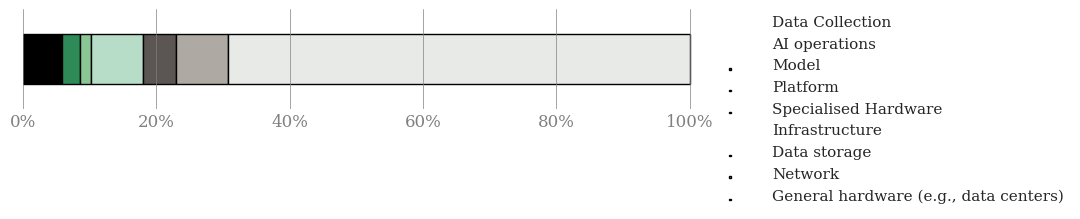

In [171]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.legend_handler import HandlerBase

# Data
topics = [
    "Data collection",
    "Model",
    "Platform",
    "Specialised Hardware",
    "Data storage",
    "Network",
    "General hardware (e.g., data centers)"
]

counts = [178, 80, 52, 239, 151, 238, 2110]

# Create a DataFrame
df = pd.DataFrame({
    'Topic': topics,
    'Count': counts
})

# Normalize the counts to percentages
total = sum(df['Count'])
df['Percentage'] = (df['Count'] / total) * 100

# Initialize the plot
fig, ax = plt.subplots(figsize=(10, 2))

# Add a light grey grid in the background
ax.set_facecolor('lightgrey')
ax.grid(which='major', axis='x', linestyle='--', color='white')

# Define colors and hatches
colors = ["black", '#2e8b57','#8ac594','#b7ddc8', '#5b5653', '#aea9a2', '#e7eae7']
hatches = [None, None, None, None, None, None, None]

# Plotting the single bar with segments
left = 0
for i, (percentage, color, hatch) in enumerate(zip(df['Percentage'], colors, hatches)):
    ax.barh(['AI pipeline'], percentage, left=left, color=color, edgecolor='black', hatch=hatch)
    left += percentage

# Adding vertical lines at every 20%
for i in range(0, 101, 20):
    ax.axvline(x=i, color='grey', linestyle='-', linewidth=0.5)
    ax.text(i, -1, f'{i}%', ha='center', va='center', color='grey')  # Adding the percentage labels

ax.set_ylim(-0.8, 0.8)

# Custom legend structure
legend_labels = [
    "Data Collection",
    "AI operations",
    "Model",
    "Platform",
    "Specialised Hardware",
    "Infrastructure",
    "Data storage",
    "Network",
    "General hardware (e.g., data centers)"
]

legend_colors = ['black', None, '#2e8b57', '#8ac594', '#b7ddc8', None, '#5b5653', '#aea9a2', '#e7eae7']
legend_hatches = [None, None, None, None, None, None, None, None, None]

# Create custom legend handles
handles = []
for color, hatch, label in zip(legend_colors, legend_hatches, legend_labels):
    if color is not None:
        patch = plt.Rectangle((0, 0), 1, 1, facecolor=color, edgecolor='black', hatch=hatch, label=label)
    else:
        patch = plt.Rectangle((0, 0), 1, 1, facecolor='none', edgecolor='none', hatch=None, label=label)
    handles.append(patch)

# Custom legend handler to indent the colored boxes
class IndentedLegendHandler(HandlerBase):
    def __init__(self, pad=0, **kwargs):
        super().__init__(**kwargs)
        self.pad = pad

    def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
        xdescent += self.pad
        return [orig_handle]

# Adjusted handles list for creating the legend
flat_handles = [
    plt.Line2D([0], [0], color='none'),  # Data Collection
    plt.Line2D([0], [0], color='none'),  # AI operations
    handles[2], handles[3], handles[4],  # AI operations topics
    plt.Line2D([0], [0], color='none'),  # Infrastructure
    handles[6], handles[7], handles[8]   # Infrastructure topics
]

# Create the legend with custom handlers
handlers = {
    handles[2]: IndentedLegendHandler(pad=20),
    handles[3]: IndentedLegendHandler(pad=20),
    handles[4]: IndentedLegendHandler(pad=20),
    handles[6]: IndentedLegendHandler(pad=20),
    handles[7]: IndentedLegendHandler(pad=20),
    handles[8]: IndentedLegendHandler(pad=20)
}

ax.legend(flat_handles, legend_labels, loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=0, frameon=False, handler_map=handlers)

# Adding grid and labels
ax.set_xticks(range(0, 101, 20))
ax.set_xticklabels([f'{i}%' for i in range(0, 101, 20)])
ax.xaxis.tick_top()

# Removing axes for cleaner look
ax.axis('off')

# Adjusting the plot layout to avoid overlap
plt.subplots_adjust(left=0.05, right=0.75, top=0.85, bottom=0.35)

# Display the plot
plt.show()


In [48]:
# Number of words to display for each topic
num_words = 20

# Get topic information
topic_info = topic_model.get_topic_info()

# Display more words for each topic
for topic_num in topic_info.Topic:
    if topic_num == -1:  # Skip outliers
        continue
    topic_words = topic_model.get_topic(topic_num)[:num_words]
    print(f"Topic {topic_num}: {topic_info.loc[topic_info.Topic == topic_num, 'Name'].values[0]}")
    for word, score in topic_words:
        print(f"{word}: {score}")
    print("\n")

Topic 0: data storage, data warehouses, data management, data center, uninterruptible power supply, power factor correction, power transfer
power: 0.07879349867104735
voltage: 0.0525116179022331
circuit: 0.043884656451695404
dc: 0.037833538725193315
converter: 0.03471258931966311
device: 0.033307862642043426
current: 0.03287416843902645
switch: 0.02406639518007213
ac: 0.023302336894062265
battery: 0.0180916097700121


Topic 1: computing hardware, processors, GPU, cooling, memory
memory: 0.06765054797308649
processor: 0.047633401548673245
computing: 0.03095708256610216
unit: 0.026601235373253377
neural: 0.026303049591558915
cache: 0.026219701883739524
performance: 0.025031739473293894
input: 0.024366529148717203
accelerator: 0.023526778470455787
hardware: 0.019242821400632982


Topic 2: sensor data collection, environmental monitoring, IoT sensors
processing: 0.04321378560664714
image: 0.04080532406933982
method: 0.038802653498026446
mobile: 0.030706099243895578
application: 0.025045423

In [ ]:
# Run the visualization with the original embeddings
topic_model.visualize_document_datamap(abstracts, embeddings=embeddings_specter)

# with the reduced embeddings
reduced_embeddings = UMAP(n_neighbors=15, n_components=2, min_dist=0.05, metric='cosine').fit_transform(embeddings_specter)
topic_model.visualize_document_datamap(abstracts, reduced_embeddings=reduced_embeddings)


In [ ]:
topic_model.visualize_heatmap()

In [60]:
timestamps = pd.to_datetime(sofai['publication_date_EPO'], format='%Y%m%d').to_list()
topics_over_time = topic_model.topics_over_time(abstracts, timestamps, nr_bins=20)
topic_model.visualize_topics_over_time(topics_over_time)

In [64]:
topics_over_time = topic_model.topics_over_time(abstracts, timestamps, nr_bins=20)

In [65]:
topic_model.visualize_topics_over_time(topics_over_time)

In [17]:
zeroshot_topic_list = [
    "sensor data collection, environmental monitoring, IoT sensors", # data collection
    "storage, storage area network, network-attached storage, distributed file system" , # data storage
    "data center, uninterruptible power supply, power distribution unit, generator, cooling, ventilation, pump, chiller", # general data center infrastructure
    "algorithmic design, model architecture, layer, deep learning, weights", # model development
    "computing hardware, processors, GPU, memory, RAM, cache, wafer-scale engines, integrated circuits, FPGA, chassis, integrated network controller", # compute
    "network infrastructure, bandwidth, data transmission, routers, cable, switch, firewall, connectivity", # network
    "deployment, edge and cloud" # deployment
    ]

topic_model = BERTopic(embedding_model=embedding_model_specter,
    min_topic_size=50,
    top_n_words=25,
    zeroshot_topic_list=zeroshot_topic_list,
    zeroshot_min_similarity=.50,
    vectorizer_model = CountVectorizer(stop_words="english"),
    representation_model= MaximalMarginalRelevance(diversity=0.4)
    #ctfidf_model=ctfidf_model
    )

# Train model
topics, probs = topic_model.fit_transform(abstracts, embeddings=embeddings_specter)

# Show topics
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,0,1909,"data center, uninterruptible power supply, pow...","[power, voltage, circuit, dc, converter, curre...",[dc power supplya dc power supply including a ...
1,1,272,"computing hardware, processors, GPU, memory, R...","[memory, chip, integrated, bus, performance, p...",[integrated circuit chip deviceprovided are an...
2,2,259,"network infrastructure, bandwidth, data transm...","[device, transmission, voice, invention, wirel...",[method and apparatus for bandwidth management...
3,3,205,"sensor data collection, environmental monitori...","[processing, method, device, application, mobi...",[information processing method and terminal de...
4,4,179,"algorithmic design, model architecture, layer,...","[neural, network, processing, layer, machine, ...",[search method for machine learning model and ...
5,5,177,"storage, storage area network, network-attache...","[memory, storage, disk, present, devices, acce...",[clock mode determination in a memory systema ...
6,6,47,"deployment, edge and cloud","[virtual, plurality, resource, device, wireles...",[method of operating a communication device an...


## field of the invention

remove empty descriptions!

In [4]:
sofai = patents_text[(patents_text['SofAI'] == 1)]

def extract_first_300_words(text):
    words = re.findall(r'\b\w+\b', text)
    return ' '.join(words[:300])
abstracts = sofai["description"].fillna('').apply(extract_first_300_words)
abstracts = abstracts.apply(str).tolist()

In [7]:
len(abstracts)

3048

In [12]:
print(abstracts[5])

In [5]:
# precalculate embeddings: 
embedding_model_specter = SentenceTransformer("sentence-transformers/allenai-specter", revision=None)
embeddings_specter = embedding_model_specter.encode(abstracts, show_progress_bar=True)        


Batches: 100%|██████████| 96/96 [02:37<00:00,  1.64s/it]


In [8]:
zeroshot_topic_list = ["sustainability", "energy efficiency", "resource efficiency", "waste reduction", "emission reduction"]

topic_model = BERTopic(embedding_model=embedding_model_specter,
    min_topic_size=50,
    top_n_words=25,
    #zeroshot_topic_list=zeroshot_topic_list,
    #zeroshot_min_similarity=.50,
    vectorizer_model = CountVectorizer(stop_words="english"),
    representation_model= MaximalMarginalRelevance(diversity=0.4)
    #ctfidf_model=ctfidf_model
    )

# Train model
topics, probs = topic_model.fit_transform(abstracts, embeddings=embeddings_specter)

# Show topics
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,0,1583,0____,"[, , , , , , , , , , , , , , , , , , , , , , ,...","[, , ]"
1,1,1465,1_power_voltage_circuit_dc,"[power, voltage, circuit, dc, invention, curre...",[technical field the present invention relates...
